In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from datetime import datetime
import seaborn as sns

In [5]:
df_2015 = pd.read_csv("cleaneddata12042018.csv", index_col=0)

In [6]:
features = pd.read_csv("determinedfeatures.csv", index_col=0)

In [7]:
features = features.values.reshape(-1).tolist()

In [8]:
df_train = df_2015.query("train_flg == 1")
df_test =df_2015.query("train_flg == 0" )

In [9]:
features.remove("train_flg")

In [10]:
print("train and test sizes:")
print(df_train.shape, df_test.shape)

train and test sizes:
(193539, 113) (64744, 113)


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_train[features], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2016, stratify = df_train.loanstatus )

In [12]:
print("X_train, X_valid, y_train, y_valid sizes:")
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

X_train, X_valid, y_train, y_valid sizes:
(135477, 109) (58062, 109) (135477,) (58062,)


In [13]:
X_test, y_test = df_test[features], df_test.loanstatus

In [14]:
print("X_test, y_test sizes:")
print(X_test.shape, y_test.shape)

X_test, y_test sizes:
(64744, 109) (64744,)


In [15]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

## Bayesian optimization

In [66]:
from bayes_opt import BayesianOptimization

xgtrain = xgb.DMatrix(df_train[features], df_train.loanstatus, missing = np.NAN)

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = False 



    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round=100000,
                       nfold=3,
                       metrics={'auc'},
                       seed=2018,
                       callbacks=[xgb.callback.early_stop(50)])
    print(cv_result)

    return cv_result['test-auc-mean'].max()

In [ ]:
xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (4, 8),
                              'min_child_weight': (0, 20),
                              'colsample_bytree': (0.2, 0.8),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2)
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=40)

In [ ]:
# Tuning results
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
print(xgb_BO_scores.head(3))

In [ ]:
xgb_BO_scores.to_csv("tuned_parameters.csv")

In [16]:
xgb_BO_scores = pd.read_csv("tuned_parameters.csv", index_col=0)

In [17]:
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
13,0.226913,0.162118,4.416750,2.799371,0.851530,0.708937
12,0.235138,1.481746,4.519245,4.289949,0.802291,0.708897
15,0.237486,1.973039,4.037854,2.733727,0.648477,0.708597
24,0.263686,0.009413,4.102331,11.646531,0.595851,0.708580
22,0.294015,0.146654,4.077396,19.703130,0.551377,0.708451


In [24]:
%%time
# parameter set 1
params = {'objective': 'binary:logistic'
                  , 'booster': 'gbtree'
                  , 'eta': 0.01
                  , 'max_depth': 4     
                  , 'min_child_weight': 3   
                  , 'subsample': 0.85   
                  , 'colsample_bytree': 0.226913  
                  , 'gamma': 0.162118               
                  , 'seed': 2018
                  , 'nthread': -1
                  , 'silence': 1
                  , 'eval_metric': 'auc'
                  , 'scale_pos_weight': 1}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round=10000
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

[20:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[0]	train-auc:0.6795	eval-auc:0.680303
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[20:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.683471	eval-auc:0.682795
[20:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-auc:0.684887	eval-auc:0.68485
[20:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-auc:0.685082	eval-auc:0.684834
[20:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-auc:0.685094	eval-auc:0.684816
[20:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned node

[20:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[53]	train-auc:0.698968	eval-auc:0.696135
[20:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[54]	train-auc:0.698988	eval-auc:0.696211
[20:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[55]	train-auc:0.698931	eval-auc:0.696264
[20:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[56]	train-auc:0.698801	eval-auc:0.696207
[20:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[57]	train-auc:0.698686	eval-auc:0.696178
[20:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[58]	train-auc:0.698621	eval-auc:0.696148
[20:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra

[20:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[107]	train-auc:0.699541	eval-auc:0.696812
[20:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[108]	train-auc:0.6996	eval-auc:0.696806
[20:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[109]	train-auc:0.699573	eval-auc:0.69678
[20:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[110]	train-auc:0.699524	eval-auc:0.696753
[20:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[111]	train-auc:0.699629	eval-auc:0.696821
[20:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[112]	train-auc:0.699565	eval-auc:0.6968
[20:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extr

[20:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[160]	train-auc:0.700818	eval-auc:0.697555
[20:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[161]	train-auc:0.700867	eval-auc:0.697587
[20:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[162]	train-auc:0.700828	eval-auc:0.69756
[20:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[163]	train-auc:0.700784	eval-auc:0.697526
[20:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[164]	train-auc:0.700813	eval-auc:0.697538
[20:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[165]	train-auc:0.700808	eval-auc:0.697545
[20:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 

[20:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[213]	train-auc:0.70223	eval-auc:0.698537
[20:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[214]	train-auc:0.702208	eval-auc:0.698531
[20:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[215]	train-auc:0.702274	eval-auc:0.698583
[20:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[216]	train-auc:0.702251	eval-auc:0.698561
[20:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[217]	train-auc:0.702233	eval-auc:0.698543
[20:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[218]	train-auc:0.70225	eval-auc:0.698553
[20:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[20:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[266]	train-auc:0.704038	eval-auc:0.699536
[20:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[267]	train-auc:0.704026	eval-auc:0.699525
[20:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[268]	train-auc:0.704072	eval-auc:0.699561
[20:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[269]	train-auc:0.704127	eval-auc:0.699586
[20:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[270]	train-auc:0.704146	eval-auc:0.699611
[20:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[271]	train-auc:0.704146	eval-auc:0.699607
[20:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[20:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[319]	train-auc:0.705711	eval-auc:0.700412
[20:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[320]	train-auc:0.705721	eval-auc:0.700413
[20:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[321]	train-auc:0.705739	eval-auc:0.700411
[20:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[322]	train-auc:0.705744	eval-auc:0.700408
[20:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[323]	train-auc:0.705747	eval-auc:0.700425
[20:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[324]	train-auc:0.705756	eval-auc:0.700431
[20:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30

[20:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[372]	train-auc:0.707344	eval-auc:0.701153
[20:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[373]	train-auc:0.707375	eval-auc:0.701167
[20:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[374]	train-auc:0.707431	eval-auc:0.701197
[20:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[375]	train-auc:0.707485	eval-auc:0.701216
[20:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[376]	train-auc:0.707513	eval-auc:0.701225
[20:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[377]	train-auc:0.70752	eval-auc:0.701227
[20:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 

[20:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[425]	train-auc:0.708849	eval-auc:0.70177
[20:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[426]	train-auc:0.708861	eval-auc:0.70177
[20:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[427]	train-auc:0.708909	eval-auc:0.701789
[20:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[428]	train-auc:0.708955	eval-auc:0.70182
[20:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[429]	train-auc:0.708988	eval-auc:0.701834
[20:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[430]	train-auc:0.709007	eval-auc:0.701844
[20:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 ex

[20:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[478]	train-auc:0.710552	eval-auc:0.7025
[20:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[479]	train-auc:0.710583	eval-auc:0.702513
[20:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[480]	train-auc:0.710606	eval-auc:0.702523
[20:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[481]	train-auc:0.710649	eval-auc:0.702543
[20:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[482]	train-auc:0.710691	eval-auc:0.702563
[20:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[483]	train-auc:0.710706	eval-auc:0.702571
[20:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[20:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[531]	train-auc:0.71211	eval-auc:0.703134
[20:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[532]	train-auc:0.712149	eval-auc:0.703138
[20:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[533]	train-auc:0.712189	eval-auc:0.703146
[20:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[534]	train-auc:0.712219	eval-auc:0.703158
[20:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[535]	train-auc:0.71225	eval-auc:0.703167
[20:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[536]	train-auc:0.712295	eval-auc:0.703187
[20:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[584]	train-auc:0.713655	eval-auc:0.703676
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[585]	train-auc:0.713674	eval-auc:0.703678
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[586]	train-auc:0.713705	eval-auc:0.703683
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[587]	train-auc:0.713741	eval-auc:0.703699
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[588]	train-auc:0.713775	eval-auc:0.703707
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[589]	train-auc:0.713817	eval-auc:0.703728
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28

[20:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[637]	train-auc:0.715196	eval-auc:0.704275
[20:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[638]	train-auc:0.715225	eval-auc:0.704288
[20:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[639]	train-auc:0.715255	eval-auc:0.704304
[20:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[640]	train-auc:0.715288	eval-auc:0.704316
[20:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[641]	train-auc:0.715318	eval-auc:0.704325
[20:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[642]	train-auc:0.71534	eval-auc:0.704342
[20:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 

[20:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[690]	train-auc:0.716636	eval-auc:0.7048
[20:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[691]	train-auc:0.716668	eval-auc:0.704807
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[692]	train-auc:0.716704	eval-auc:0.704818
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[693]	train-auc:0.716726	eval-auc:0.704825
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[694]	train-auc:0.716766	eval-auc:0.704837
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[695]	train-auc:0.716799	eval-auc:0.704853
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[20:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[743]	train-auc:0.718118	eval-auc:0.705223
[20:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[744]	train-auc:0.718144	eval-auc:0.705229
[20:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[745]	train-auc:0.718171	eval-auc:0.705242
[20:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[746]	train-auc:0.718197	eval-auc:0.705247
[20:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[747]	train-auc:0.718224	eval-auc:0.705261
[20:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[748]	train-auc:0.71825	eval-auc:0.705262
[20:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 

[20:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[796]	train-auc:0.719531	eval-auc:0.705641
[20:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[797]	train-auc:0.719557	eval-auc:0.705655
[20:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[798]	train-auc:0.719587	eval-auc:0.705663
[20:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[799]	train-auc:0.71961	eval-auc:0.705661
[20:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[800]	train-auc:0.719627	eval-auc:0.705664
[20:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[801]	train-auc:0.719657	eval-auc:0.70567
[20:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 e

[20:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[849]	train-auc:0.720844	eval-auc:0.70602
[20:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[850]	train-auc:0.720867	eval-auc:0.706025
[20:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[851]	train-auc:0.720892	eval-auc:0.706032
[20:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[852]	train-auc:0.720918	eval-auc:0.706041
[20:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[853]	train-auc:0.720935	eval-auc:0.706044
[20:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[854]	train-auc:0.720953	eval-auc:0.706055
[20:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 

[20:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[902]	train-auc:0.722119	eval-auc:0.706355
[20:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[903]	train-auc:0.722153	eval-auc:0.706376
[20:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[904]	train-auc:0.722172	eval-auc:0.706381
[20:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[905]	train-auc:0.722205	eval-auc:0.706387
[20:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[906]	train-auc:0.722234	eval-auc:0.7064
[20:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[907]	train-auc:0.722254	eval-auc:0.7064
[20:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 ext

[20:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[955]	train-auc:0.723341	eval-auc:0.706678
[20:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[956]	train-auc:0.723358	eval-auc:0.706681
[20:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[957]	train-auc:0.723381	eval-auc:0.706683
[20:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[958]	train-auc:0.723407	eval-auc:0.706689
[20:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[959]	train-auc:0.72344	eval-auc:0.706698
[20:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[960]	train-auc:0.723469	eval-auc:0.706698
[20:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 

[20:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1008]	train-auc:0.724446	eval-auc:0.70687
[20:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1009]	train-auc:0.724464	eval-auc:0.706867
[20:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1010]	train-auc:0.72448	eval-auc:0.706868
[20:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1011]	train-auc:0.72451	eval-auc:0.706868
[20:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1012]	train-auc:0.724526	eval-auc:0.706873
[20:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1013]	train-auc:0.724554	eval-auc:0.706881
[20:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[20:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1061]	train-auc:0.725561	eval-auc:0.707044
[20:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1062]	train-auc:0.725586	eval-auc:0.70705
[20:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1063]	train-auc:0.7256	eval-auc:0.70705
[20:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1064]	train-auc:0.725625	eval-auc:0.707048
[20:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1065]	train-auc:0.725639	eval-auc:0.707049
[20:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1066]	train-auc:0.725652	eval-auc:0.707055
[20:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[20:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1114]	train-auc:0.726582	eval-auc:0.707242
[20:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1115]	train-auc:0.726613	eval-auc:0.707245
[20:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1116]	train-auc:0.726631	eval-auc:0.707251
[20:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1117]	train-auc:0.726652	eval-auc:0.707254
[20:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1118]	train-auc:0.726672	eval-auc:0.707259
[20:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1119]	train-auc:0.726686	eval-auc:0.70726
[20:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[20:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1167]	train-auc:0.727682	eval-auc:0.707472
[20:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1168]	train-auc:0.727697	eval-auc:0.707469
[20:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1169]	train-auc:0.727722	eval-auc:0.707478
[20:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1170]	train-auc:0.727726	eval-auc:0.707477
[20:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1171]	train-auc:0.727747	eval-auc:0.707479
[20:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1172]	train-auc:0.727769	eval-auc:0.707489
[20:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[20:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1220]	train-auc:0.728693	eval-auc:0.707626
[20:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1221]	train-auc:0.728716	eval-auc:0.707619
[20:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1222]	train-auc:0.72874	eval-auc:0.707617
[20:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1223]	train-auc:0.72876	eval-auc:0.707624
[20:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1224]	train-auc:0.728783	eval-auc:0.707633
[20:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1225]	train-auc:0.728802	eval-auc:0.707636
[20:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[20:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1273]	train-auc:0.729629	eval-auc:0.70778
[20:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1274]	train-auc:0.729639	eval-auc:0.707779
[20:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1275]	train-auc:0.729662	eval-auc:0.707785
[20:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[1276]	train-auc:0.72967	eval-auc:0.707782
[20:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1277]	train-auc:0.729687	eval-auc:0.707782
[20:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1278]	train-auc:0.729708	eval-auc:0.707783
[20:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[20:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1326]	train-auc:0.73054	eval-auc:0.707916
[20:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1327]	train-auc:0.730547	eval-auc:0.707911
[20:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1328]	train-auc:0.730557	eval-auc:0.707909
[20:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1329]	train-auc:0.730578	eval-auc:0.707917
[20:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1330]	train-auc:0.730588	eval-auc:0.707918
[20:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1331]	train-auc:0.730607	eval-auc:0.707912
[20:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[20:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1379]	train-auc:0.731409	eval-auc:0.708018
[20:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1380]	train-auc:0.731433	eval-auc:0.708015
[20:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1381]	train-auc:0.731449	eval-auc:0.708015
[20:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1382]	train-auc:0.73146	eval-auc:0.708017
[20:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1383]	train-auc:0.731477	eval-auc:0.708023
[20:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1384]	train-auc:0.73149	eval-auc:0.708026
[20:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[20:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1432]	train-auc:0.732251	eval-auc:0.70812
[20:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1433]	train-auc:0.732266	eval-auc:0.708125
[20:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[1434]	train-auc:0.732269	eval-auc:0.708126
[20:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1435]	train-auc:0.732288	eval-auc:0.708129
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1436]	train-auc:0.732311	eval-auc:0.708122
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1437]	train-auc:0.732327	eval-auc:0.708127
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[20:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1485]	train-auc:0.733093	eval-auc:0.708208
[20:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1486]	train-auc:0.733121	eval-auc:0.70821
[20:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1487]	train-auc:0.733146	eval-auc:0.708212
[20:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1488]	train-auc:0.733165	eval-auc:0.708213
[20:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1489]	train-auc:0.733178	eval-auc:0.708215
[20:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1490]	train-auc:0.733187	eval-auc:0.708218
[20:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[20:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[1538]	train-auc:0.733871	eval-auc:0.70827
[20:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1539]	train-auc:0.733894	eval-auc:0.708276
[20:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1540]	train-auc:0.733908	eval-auc:0.708276
[20:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1541]	train-auc:0.733929	eval-auc:0.708283
[20:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1542]	train-auc:0.733951	eval-auc:0.708288
[20:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1543]	train-auc:0.733959	eval-auc:0.70829
[20:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[20:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1591]	train-auc:0.734748	eval-auc:0.70837
[20:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1592]	train-auc:0.734766	eval-auc:0.70837
[20:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1593]	train-auc:0.734778	eval-auc:0.70837
[20:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1594]	train-auc:0.73479	eval-auc:0.708374
[20:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1595]	train-auc:0.734807	eval-auc:0.708373
[20:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1596]	train-auc:0.734828	eval-auc:0.708373
[20:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[20:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[1644]	train-auc:0.735572	eval-auc:0.7085
[20:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1645]	train-auc:0.735589	eval-auc:0.708502
[20:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1646]	train-auc:0.735611	eval-auc:0.708512
[20:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1647]	train-auc:0.735632	eval-auc:0.708511
[20:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1648]	train-auc:0.735641	eval-auc:0.708511
[20:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[1649]	train-auc:0.735649	eval-auc:0.708508
[20:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1697]	train-auc:0.736408	eval-auc:0.708566
[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1698]	train-auc:0.73643	eval-auc:0.708571
[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1699]	train-auc:0.73645	eval-auc:0.708567
[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1700]	train-auc:0.736458	eval-auc:0.708568
[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1701]	train-auc:0.736472	eval-auc:0.708569
[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1702]	train-auc:0.736495	eval-auc:0.708574
[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[20:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1750]	train-auc:0.737059	eval-auc:0.708594
[20:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1751]	train-auc:0.737074	eval-auc:0.708598
[20:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1752]	train-auc:0.737095	eval-auc:0.708597
[20:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1753]	train-auc:0.737108	eval-auc:0.708598
[20:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1754]	train-auc:0.737121	eval-auc:0.708607
[20:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1755]	train-auc:0.73714	eval-auc:0.708605
[20:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[20:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1803]	train-auc:0.737903	eval-auc:0.708717
[20:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1804]	train-auc:0.737922	eval-auc:0.708709
[20:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1805]	train-auc:0.737941	eval-auc:0.708717
[20:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1806]	train-auc:0.737955	eval-auc:0.708718
[20:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[1807]	train-auc:0.737963	eval-auc:0.708715
[20:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1808]	train-auc:0.737981	eval-auc:0.708718
[20:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[20:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1856]	train-auc:0.738709	eval-auc:0.708763
[20:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1857]	train-auc:0.738712	eval-auc:0.708764
[20:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1858]	train-auc:0.738735	eval-auc:0.708777
[20:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1859]	train-auc:0.738756	eval-auc:0.708779
[20:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1860]	train-auc:0.738771	eval-auc:0.708784
[20:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1861]	train-auc:0.738785	eval-auc:0.708789
[20:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[20:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[1909]	train-auc:0.739416	eval-auc:0.708835
[20:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1910]	train-auc:0.739422	eval-auc:0.708834
[20:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1911]	train-auc:0.73944	eval-auc:0.70884
[20:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[1912]	train-auc:0.739451	eval-auc:0.708837
[20:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1913]	train-auc:0.739473	eval-auc:0.70884
[20:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1914]	train-auc:0.739493	eval-auc:0.708836
[20:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[20:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1962]	train-auc:0.740145	eval-auc:0.708899
[20:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1963]	train-auc:0.740166	eval-auc:0.7089
[20:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1964]	train-auc:0.740187	eval-auc:0.708903
[20:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1965]	train-auc:0.740205	eval-auc:0.708914
[20:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[1966]	train-auc:0.740215	eval-auc:0.708913
[20:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1967]	train-auc:0.740233	eval-auc:0.708914
[20:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[20:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2015]	train-auc:0.740978	eval-auc:0.708974
[20:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2016]	train-auc:0.741002	eval-auc:0.708975
[20:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2017]	train-auc:0.741016	eval-auc:0.708976
[20:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[2018]	train-auc:0.741027	eval-auc:0.708977
[20:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2019]	train-auc:0.741041	eval-auc:0.708985
[20:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2020]	train-auc:0.741061	eval-auc:0.70898
[20:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[20:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2068]	train-auc:0.741762	eval-auc:0.709026
[20:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2069]	train-auc:0.741775	eval-auc:0.709031
[20:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2070]	train-auc:0.741789	eval-auc:0.709033
[20:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[2071]	train-auc:0.741806	eval-auc:0.709032
[20:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2072]	train-auc:0.741809	eval-auc:0.709029
[20:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[2073]	train-auc:0.741818	eval-auc:0.70903
[20:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[20:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[2121]	train-auc:0.742547	eval-auc:0.709032
[20:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[2122]	train-auc:0.742552	eval-auc:0.709032
[20:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2123]	train-auc:0.742573	eval-auc:0.709029
[20:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2124]	train-auc:0.742589	eval-auc:0.70903
[20:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2125]	train-auc:0.742618	eval-auc:0.709035
[20:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2126]	train-auc:0.742636	eval-auc:0.709036
[20:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2174]	train-auc:0.743285	eval-auc:0.70905
[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2175]	train-auc:0.743294	eval-auc:0.709048
[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[2176]	train-auc:0.743309	eval-auc:0.709053
[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2177]	train-auc:0.743327	eval-auc:0.709049
[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2178]	train-auc:0.743337	eval-auc:0.709049
[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[2179]	train-auc:0.74335	eval-auc:0.709051
[20:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[20:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2227]	train-auc:0.744026	eval-auc:0.709065
[20:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[2228]	train-auc:0.744033	eval-auc:0.709062
[20:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[2229]	train-auc:0.744043	eval-auc:0.709063
[20:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2230]	train-auc:0.744064	eval-auc:0.709061
[20:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2231]	train-auc:0.744087	eval-auc:0.709064
[20:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2232]	train-auc:0.744099	eval-auc:0.709066
[20:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[20:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[2280]	train-auc:0.744771	eval-auc:0.709092
[20:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[2281]	train-auc:0.744782	eval-auc:0.709095
[20:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2282]	train-auc:0.744799	eval-auc:0.709095
[20:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[2283]	train-auc:0.744812	eval-auc:0.709095
[20:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[2284]	train-auc:0.744818	eval-auc:0.709091
[20:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2285]	train-auc:0.744842	eval-auc:0.709089
[20:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[20:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2333]	train-auc:0.745499	eval-auc:0.70908
[20:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[2334]	train-auc:0.745511	eval-auc:0.709073
[20:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[2335]	train-auc:0.745521	eval-auc:0.709075
[20:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[2336]	train-auc:0.745525	eval-auc:0.709074
[20:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2337]	train-auc:0.745546	eval-auc:0.70907
[20:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[2338]	train-auc:0.745558	eval-auc:0.709072
[20:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

In [19]:
train_x = df_train[features]
train_y = df_train.loanstatus
best_xgb_iteration=2291
clf_train = xgb.XGBClassifier(learning_rate = 0.01
                  , n_estimators =best_xgb_iteration
                  , max_depth = 4
                  , min_child_weight = 3
                  , subsample = 0.85
                  , colsample_bytree = 0.226913 
                  , gamma = 0.162118
                  , seed = 2018
                  , nthread = -1
                  , scale_pos_weight = 1
                  )

clf_train.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.226913, gamma=0.162118, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
       n_estimators=2291, n_jobs=1, nthread=-1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=2018, silent=True,
       subsample=0.85)

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print("Area under the ROC curve - validation: %f" % roc_auc)
    print( "Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - test(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - train (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.savefig("ROC.png", dpi=300)
    plt.show()

Area under the ROC curve - validation: 0.709100
Area under the ROC curve - train: 0.744910
Area under the ROC curve - test: 0.718062


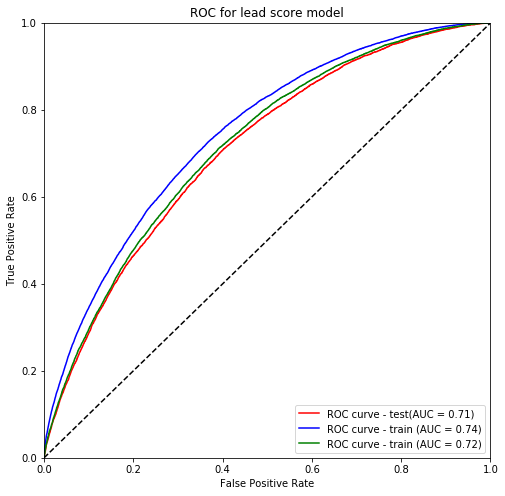

In [26]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

In [27]:
y_pred = gbm.predict(dtest)

In [28]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.6647537 0.0055324407 0.14294212


In [29]:
importance=gbm.get_fscore()

In [30]:
df_importance = pd.DataFrame.from_dict(importance, orient="index", columns=["weight"])

In [31]:
df_importance.sort_values(['weight'], ascending=False, inplace=True)
df_importance['weight'] = df_importance['weight'] / df_importance['weight'].sum()

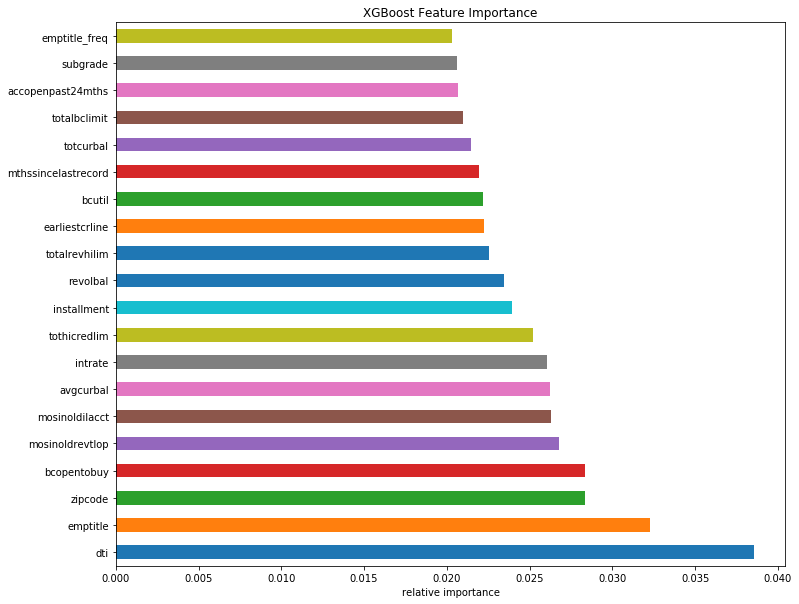

In [34]:
# df_importance.plot()
df_importance[:20].plot(kind='barh', y='weight', legend=False, figsize=(12, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.savefig('feature_importance_xgb1210.png', dpi=300)

Text(0.5, 0, 'relative importance')

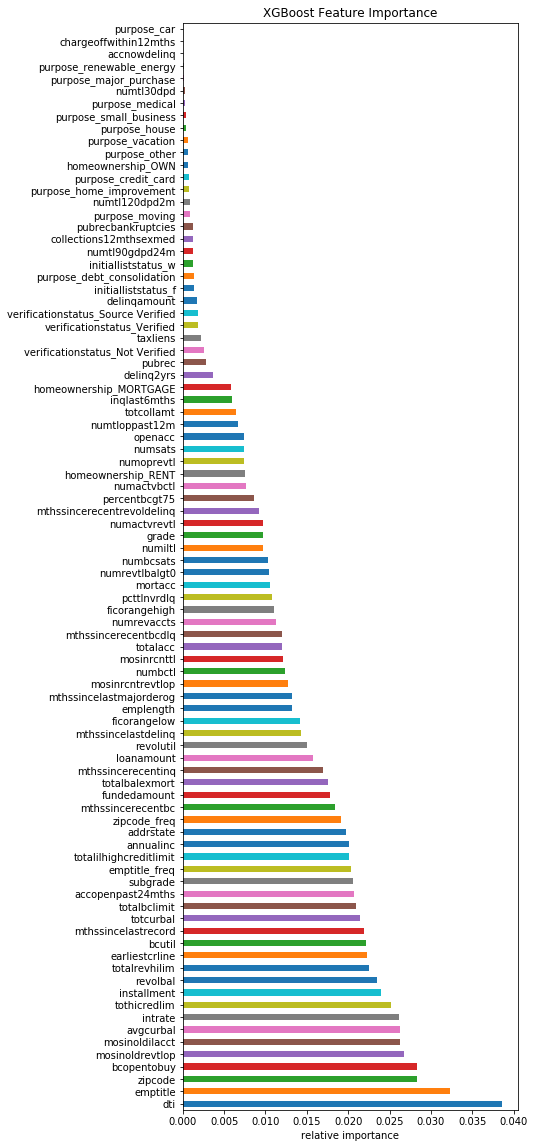

In [31]:
# df_importance.plot()
df_importance.plot(kind='barh', y='weight', legend=False, figsize=(6, 20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [32]:
import pickle

In [33]:
with open('model1207.pkl','wb') as pkl_file:
    pickle.dump(gbm, pkl_file)

In [34]:
from sklearn.externals import joblib
joblib.dump(gbm, "gbm1207.joblib")

['gbm1207.joblib']